<a href="https://colab.research.google.com/github/PhillipTodorov/GoogleColabRepo/blob/master/8_2_1_implementing_DeepDream_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#8.2.1 implementing DeepDream in Keras

DeepDream algorithm is similar to the convnet filter-visualisation technique, which involved running a convnet in reverse, doing gradient ascent on the input to the convnet in order to maximise the specific filter in an upper layer of the convnet.

DeepDream is slightly different in that:


*   DeepDream tries to maximize the activation of all the layers rather than any specific layer, which mixes the visualisations of all the features at once.
*   You start from an existing image instead of a blank canvas with a bit of noise which means that the resulting effect draws from the original image. 
*   Process the images at different scales, called **octaves**, to improve visualisations.
* An octave is essentially looking at an image at a smaller scale by zooming in , then running a gradient ascent on that scale, then running a gradient ascent on a scaled up version of that image.





In [0]:
#we can use any convnet we want but DeepDream works well with Inception V3

In [0]:
#Loading the pretrained Inception V3 model

In [4]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)#this disables all training specific operations as these wont be used for this

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)#builds V3 network without convolutional base as it will be loaded with pretrained imagenet weights.

Using TensorFlow backend.














87916544/87910968 [==============================] - 3s 0us/step


Next will be computing the loss which is the quantity you wish to maximise during the gradient-ascent process. Unlike before, here we are trying to maximise the filters in multiple layers at once, specifically the weighted sum of the L2 norm of the activation of a set of high-level layers.

The L2 norm is calculated as the square root of the sum of the squared vector values.





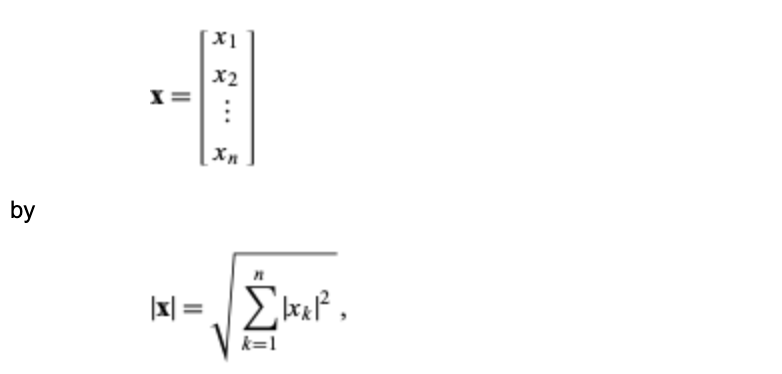

The exact layers you choose has a major influence on the visuals you produce, so you want to make these easily configurable.

In [0]:
#Setting up the DeepDream configuration

In [0]:
layer_contributions = {
    'mixed2' : 0.2,
    'mixed3' : 3.,
    'mixed4' : 2.,
    'mixed5' : 1.5,
}#these layer names are hardcoded, the values represent how much their activation contributes to the loss you want to maximise

In [0]:
#Defining the loss to be maximised 

In [8]:
layer_dict = dict([(layer.name, layer) for layer in model.layers]) #creates a dictionary of the layers in the model, where layer.name is the name and layer is the value

loss = K.variable(0.)#define the loss by adding layer contributions to this scalar variable
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]#assigns the associated layer weighting to coeff
  activation = layer_dict[layer_name].output#retrieves the layer output

  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss += coeff * K.sum(K.square(activation[:,2:-2,2:-2,:])) / scaling #adds the L2 norm of the features of a layer to the loss.


In [0]:
#setting up the gradient-ascent process

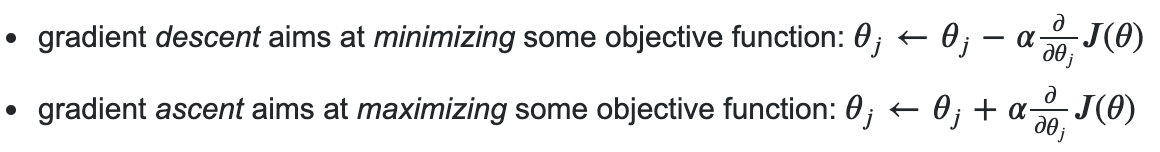

In [0]:
dream = model.input #this is what holds the generated image, it is a tensor object

grads = K.gradients(loss, dream)[0] #computes the gradients of the dream with regard to the loss

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) #normalises the gradients

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs) #sets up a keras function to retrieve the value of the loss and gradients, given an input image 

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])#runs fetch_loss_and_grads on ([x],[loss,grads])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):#this function runs gradient ascent on a number of iterations 
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x) 
    if max_loss is not None and loss_value > max_loss:
      break
    print('...Loss value at', i,':', loss_value)
    x += step * grad_values
  return x

Finally the DeepDream algorithm. First you define a list of octaves to process the images at. Each successive scale is larger by a factor of 1.4. You start by processing a smaller image then successively scaling up.

You process each scaled up image aswell, inorder to avoid losing too much detail after each scale up, you reinject the lost detail from the original image.

You so this by comparing the small image S and the large image L and finding the difference between the two, this difference quantifies the details lost.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
!ls "/content/drive/My Drive/Colab Notebooks/81845562_602772407204742_1443464681992749056_n.jpg"

'/content/drive/My Drive/Colab Notebooks/81845562_602772407204742_1443464681992749056_n.jpg'


In [0]:
#Auxiliary functions

In [0]:
import scipy
import imageio
from keras.preprocessing import image 



def resize_img(img, size):
  img = np.copy(img)
  factors = (1, float(size[0])/img.shape[1], float(size[1])/img.shape[2], 1)
  return scipy.ndimage.zoom(img,factors, order=1)

def save_img(img,fname): 
  pil_img = deprocess_image(np.copy(img))
  imageio.imsave(fname, pil_img)

def preprocess_image(image_path):
  img = image.load_img(image_path)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img 

def deprocess_image(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1,2,0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2. 
  x += 0.5
  x *= 255.
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
#Running gradient ascent over different successive scales

In [26]:
import numpy as np 


step = 0.01 #gradient step size 
num_octave = 3 
octave_scale = 1.4 #how much to increase octave at each iteration
iterations = 20

max_loss = 10. #when comparing the the upscaled image, if the loss is greater than max_loss, interupt the gradient descent process

base_image_path = "/content/drive/My Drive/Colab Notebooks/81845562_602772407204742_1443464681992749056_n.jpg"

img = preprocess_image(base_image_path) #load image into numpy array

original_shape = img.shape[1:3] #prepares a list of shape tuples defining the different scales at which to run gradient ascent
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1] #reverses the list of shapes so theyre in increaseing order 

original_img = np.copy(img) #resize the numpy array of the image to the smallest scale
shrunk_original_img = resize_img(img, successive_shapes[0])#using the tuple as the (x,y) scaling values

for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape) #scales up the dream image
  img = gradient_ascent(img, 
                        iterations=iterations,
                        step=step,
                        max_loss=max_loss) #runs gradient ascent altering the dream image
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) #scales up the smaller version of the original image: it will be pixelated
  same_size_original = resize_img(original_img,shape) #computes the high-quality version of the original image at this size 
  lost_detail = same_size_original - upscaled_shrunk_original_img #the difference between the two is the detail that was lost when scaling up

  img += lost_detail #reinjects the lost detail into the dream 
  shrunk_original_img = resize_img(original_img, shape) 
  save_img(img, fname='dream_at_scale' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (680, 382)
...Loss value at 0 : 1.8329282
...Loss value at 1 : 2.484874
...Loss value at 2 : 3.3739617
...Loss value at 3 : 4.3245654
...Loss value at 4 : 5.2976813
...Loss value at 5 : 6.228157
...Loss value at 6 : 7.1206083
...Loss value at 7 : 7.916732
...Loss value at 8 : 8.728082
...Loss value at 9 : 9.414769
Processing image shape (952, 535)
...Loss value at 0 : 3.4720113
...Loss value at 1 : 4.926198
...Loss value at 2 : 6.1174016
...Loss value at 3 : 7.171053
...Loss value at 4 : 8.104186
...Loss value at 5 : 8.983133
...Loss value at 6 : 9.787296
Processing image shape (1334, 750)
...Loss value at 0 : 3.5083327
...Loss value at 1 : 4.82917
...Loss value at 2 : 5.971516
...Loss value at 3 : 6.9950533
...Loss value at 4 : 7.951465
...Loss value at 5 : 8.843798
...Loss value at 6 : 9.672234
